In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from surprise import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data loading

In [2]:
from helpers import load_data_surprise, load_data_matrix

DATA_PATH = 'data/'

In [3]:
dataset, dataframe = load_data_surprise(DATA_PATH + 'data_train.csv')

In [4]:
data_matrix = load_data_matrix(DATA_PATH + 'data_train.csv')

# Data exploration

In [5]:
from plots import plot_number_of_ratings

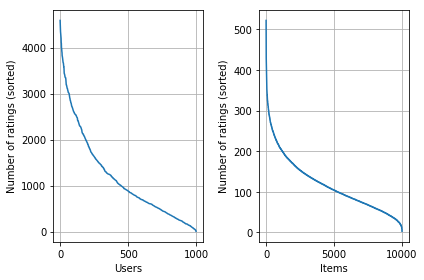

In [6]:
plot_number_of_ratings(data_matrix)

# 1. Load custom Surprise Dataset

In [7]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import accuracy

In [8]:
#Test loading with a simple SVD based prediction

from surprise.model_selection import train_test_split
trainset, testset = train_test_split(dataset, test_size=.25)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 1.0274


1.0273567440846878

# 2. SVD Model 

In [9]:
#first we're going to chose the compare some parameters such as k, learning rate
#then we will do a cross_validation analysis

from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs':[10],'n_factors':[40,50], 'lr_all': [0.005],
              'reg_all': [0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(dataset)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0178368618558986
{'n_epochs': 10, 'n_factors': 40, 'lr_all': 0.005, 'reg_all': 0.4}


In [10]:
# 80/20 % split with k=50 factors

trainset, testset = train_test_split(dataset, test_size=.20)
algo = SVD()
algo.n_factors=50
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 1.0175


1.0175306468374248

In [11]:
from surprise.model_selection import cross_validate

algo.n_epochs=10
cross_validate(algo,dataset, measures=['rmse'], cv=5, return_train_measures=True)

{'test_rmse': array([1.0079056 , 1.00250377, 1.008308  , 1.00490506, 1.00592003]),
 'train_rmse': array([0.95173932, 0.95173725, 0.95126572, 0.95139043, 0.95146363]),
 'fit_time': (23.641764879226685,
  22.800864219665527,
  22.100563049316406,
  22.155883073806763,
  22.03102421760559),
 'test_time': (3.407252073287964,
  3.1310739517211914,
  3.134770154953003,
  3.088960886001587,
  3.088762044906616)}

# 3. NMF Model

In [12]:
#first we're going to chose the compare some parameters such as k, learning rate
#then we will do a cross_validation analysis

from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs':[50],'n_factors':[2], 'biased': [True],'reg_pu':[0.06,0.1]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=4)
gs.fit(dataset)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.003921669641397
{'n_epochs': 50, 'n_factors': 2, 'biased': True, 'reg_pu': 0.06}


In [13]:
trainset, testset = train_test_split(dataset, test_size=.50)
algo = NMF()
algo.n_factors=2
algo.biased=True
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 1.0053


1.0053239228448108

# 4. Output submission 

## 4.1 Load and preprocessing of sampleSubmission

In [18]:
sample_dataset, sample_dataframe = load_data_surprise(DATA_PATH + 'sampleSubmission.csv')

## 4.2 Final Model

In [16]:
fullset = dataset.build_full_trainset()
final_algo = NMF()
final_algo.n_factors = 2
final_algo.biased = True
final_algo.fit(fullset)

In [20]:
sub_data_set = sample_dataset.build_full_trainset()
pred = final_algo.test(sub_data_set.build_testset())

## 4.3 Write output submission to CSV

In [21]:
import csv
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Id', 'Prediction'])
    for p in pred:
        writer.writerow([p[0] + '_' + p[1], round(p[3])])